# CPSC 330 Lecture 8

#### Lecture plan

- Precision, recall, confusion matrices (15 min)
- Evaluation metrics True/False (10 min)
- ROC (20 min)
- Break (5 min)
- Addressing class imbalance (10 min)
- Stratified splits (5 min)
- This week - summary (5 min)


In [2]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
plt.rcParams['font.size'] = 16

Extra dependency for the next import:

```
pip install scikit-optimize
```

In [4]:
from skopt import BayesSearchCV

The following import requires scikit-learn version >= 0.22.1:

In [5]:
import sklearn
sklearn.__version__

'0.22.1'

In [6]:
from sklearn.metrics import plot_confusion_matrix

In [7]:
def show_scores(model, X_train, y_train, X_valid, y_valid):
    print("Training error: %.4f" % ((1-model.score(X_train, y_train))))
    print("Test     error: %.4f" % ((1-model.score(X_valid, y_valid))))
def show_scores_percent(model, X_train, y_train, X_valid, y_valid):
    print("Training error: %.3f%%" % (100*(1-model.score(X_train, y_train))))
    print("Test     error: %.3f%%" % (100*(1-model.score(X_valid, y_valid))))

## Precision, recall, confusion matrices (15 min)

- Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.
- For confidentially reasons, it only provides transformed features with PCA

In [8]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
X = cc_df.drop(columns = ['Class'])
y = cc_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=111)

- At this point we would want to thinm more carefully about the Time and Amount variables.
- We could scale Amount, but do we want to scale Time?
- More on time series coming later in the course.

In [10]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,1.345904,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,-0.192932,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.178761,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,-0.040448,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.430295,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50


In [11]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train);

In [12]:
show_scores(lr, X_train, y_train, X_test, y_test)

Training error: 0.0008
Test     error: 0.0009


In [13]:
svm = SVC(max_iter=500, gamma='scale')
svm.fit(X_train, y_train);

In [14]:
show_scores(svm, X_train, y_train, X_test, y_test)

Training error: 0.0017
Test     error: 0.0018


- We have an excellent accuracy!! 
- But how reliable is it?
- Would this model be able to identify fraudulent transactions? 
- Let's examine to what extent the model is able to identify fraudulent transactions.

In [15]:
### What's the class distribution
cc_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [16]:
confusion_matrix(y_test, lr.predict(X_test))

array([[85263,    27],
       [   52,   101]])

You can use `confusion_matrix` instead of `plot_confusion_matrix` if your version of scikit-learn is too old.

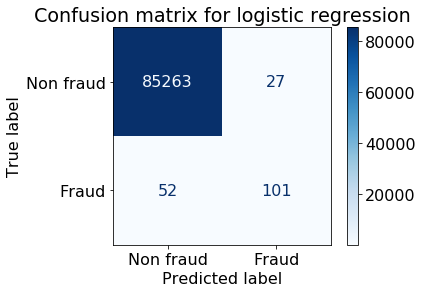

In [20]:
disp = plot_confusion_matrix(lr, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for logistic regression');

In [266]:
print(disp.confusion_matrix)

[[85263    27]
 [   52   101]]


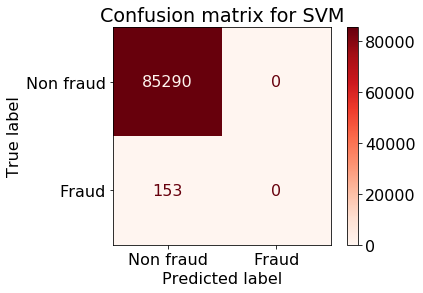

In [267]:
disp_svm = plot_confusion_matrix(svm, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Reds, 
                             values_format = 'd')
disp_svm.ax_.set_title('Confusion matrix for SVM');

In [268]:
print(disp_svm.confusion_matrix)

[[85290     0]
 [  153     0]]


**Caution**: 

- scikit-learn's convention is to have true label as the rows, predicted as the columns. 
- Others do it the other way around, e.g. the [confusion matrix Wikipedia article](https://en.wikipedia.org/wiki/Confusion_matrix). 
- You can always transpose the confusion matrix with `.T`:

In [269]:
print(disp_svm.confusion_matrix.T)

[[85290   153]
 [    0     0]]


However, there doesn't seem to be a way with `plot_confusion_matrix`.

### Let's understand confusion matrix

Using the sklearn convention:

|   X   | predict negative | predict positive |
|------|----------|-------|
| negative example | True negative (TN) | False positive (FP)|
| positive example | False negative (FN) | True positive (TP) |

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

#### Accuracy does not tell the whole story!

- Accuracy is misleading when we have class imbalance. 
- We need other metrics to evaluate our models. 
- We'll first discuss model evaluation.
- And then what can be done about class imbalance.

Evaluation metrics cheat sheet:

<img src='img/evaluation_metrics.png' width="800"/>

#### Precision and recall

Recall: how many of the actual positive examples did you identify?

Precision: of the positive examples you identify, how many were real?

- Consider a disease diagnosis system. Suppose you have 100 examples: 20 with disease = 'yes' and 80 with disease = 'no'. 
- High precision system example: Consider a very conservative system that classifies examples as 'yes' only in the presence of certain value for a strong feature. Suppose in your dataset there is only one such example. 
    - Precision = TP/(TP + FP) = 1 / (1 + 0) = 1
    - What's the recall in this case? 
- High recall system example: Consider a system which generously classifies all examples as 'yes'. 
    - Recall = TP/(TP + FN) = 20 / (20 + 0) = 1
    - What's the precision in this case? 

- Note: you may have heard other terms like sensitivity and specificity. 
- See the [MDS terminology document](https://ubc-mds.github.io/resources_pages/terminology/) for more info.

#### Type I, Type II errors

- Type I error is another name for false positive
- Type II error is another name for false negative


In [270]:
predictions = lr.predict(X_test)
TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
print('Confusion matrix for fraud data set')
print(confusion_matrix(y_test, predictions))

Confusion matrix for fraud data set
[[85263    27]
 [   52   101]]


In [271]:
#### Calculate evaluation metrics 

accuracy = (TP+TN)/(TN+FP+FN+TP)
error = (FP+FN)/(TN+FP+FN+TP)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1 = 2* (precision * recall)/(precision + recall)
data = {}
data['accuracy'] = [accuracy]
data['error'] = [error]
data['precision'] = [precision]
data['recall'] = [recall]
data['f1'] = [f1]

metrics_df = pd.DataFrame(data)
metrics_df

,accuracy,error,precision,recall,f1
0,0.999075,0.000925,0.789062,0.660131,0.718861


In [272]:
from sklearn.metrics import classification_report

In [273]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85290
           1       0.79      0.66      0.72       153

    accuracy                           1.00     85443
   macro avg       0.89      0.83      0.86     85443
weighted avg       1.00      1.00      1.00     85443



The above is for logistic regression. We can do the same for the SVM:

In [274]:
print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85290
           1       0.00      0.00      0.00       153

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



/Users/mgelbart/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note: it can be useful to normalize the confusion matrix so that it shows proportions:

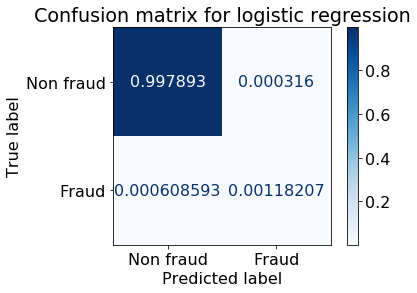

In [275]:
disp = plot_confusion_matrix(lr, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='all')
disp.ax_.set_title('Confusion matrix for logistic regression');

You can normalize in various ways, and thus read precision/recall right off the graph:

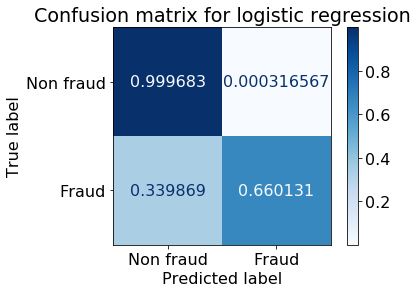

In [276]:
disp = plot_confusion_matrix(lr, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='true')
disp.ax_.set_title('Confusion matrix for logistic regression');

In [277]:
metrics_df

,accuracy,error,precision,recall,f1
0,0.999075,0.000925,0.789062,0.660131,0.718861


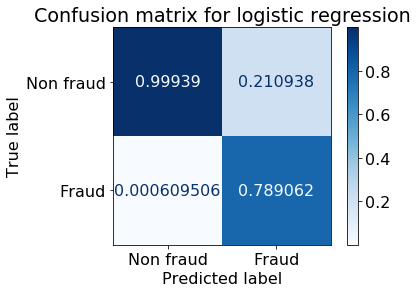

In [278]:
disp = plot_confusion_matrix(lr, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='pred')
disp.ax_.set_title('Confusion matrix for logistic regression');

#### Confusion matrix for multi-class: 

- We will talk about multi-class classification later.
- But for now, FYI we can still compute a confusion matrix, e.g.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_001.png)

## Evaluation metrics True/False (15 min)

1. In medical diagnosis, false positives are more damaging than false negatives (assume "positive" means the person has a disease, "negative" means they don't).
2. In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means they it's not).
3. In the medical diagnosis, high recall is more important than high precision.
4. If method A gets a higher accuracy than method B, that means its precision is also higher.
5. If method A gets a higher accuracy than method B, that means its recall is also higher.

<br><br><br><br><br><br><br><br><br>

## Receiver Operating Characteristic (ROC) Curve (10 min)

- What if you care about certain types of mistakes more than others?
- In the medical diagnosis example, you want to be conservative and bias the model towards predicting "positive".
- We said earlier that `predict` returns 1 when `predict_proba`'s probabilities is above 0.5.
- Key idea: what if we threshold the probability at a different values?

In [279]:
confusion_matrix(y_test, lr.predict(X_test))

array([[85263,    27],
       [   52,   101]])

In [280]:
confusion_matrix(y_test, lr.predict_proba(X_test)[:,1]>0.5)

array([[85263,    27],
       [   52,   101]])

In [281]:
confusion_matrix(y_test, lr.predict_proba(X_test)[:,1]>0.4)

array([[85258,    32],
       [   49,   104]])

In [282]:
confusion_matrix(y_test, lr.predict_proba(X_test)[:,1]>0.3)

array([[85255,    35],
       [   42,   111]])

- As we lower the threshold for classifying something as fraudulent, we end up predicting more fraud. 
- (Strangely, doing so seems to improve overall accuracy in this case! That shouldn't be true in general...)

#### ROC curve

- [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) looks at what happens as you change this threshold.
- ROC plots true positive rate (recall) ($\frac{TP}{TP + FN}$) against false positive rate ($\frac{FP}{\# negatives }$) 
- Note that the "C" doesn't stand for "curve", so saying "ROC curve" isn't like saying "PIN number" or "SIN number".
- The diagonal line is what happens if your guesses are random.

In [283]:
from sklearn.metrics import roc_curve

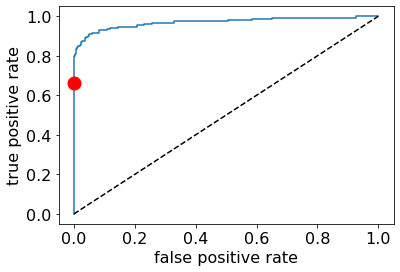

In [294]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
ind = np.argmin(np.abs(thresholds-0.5))
plt.plot(fpr[ind], tpr[ind], 'ro', markersize=13)
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');

Above: the red circle corresponds to the threshold of 0.5, which is used by `predict`.

- If the threshold is 1, we always predict "negative".
  - the true positive rate is 0 because there are no true positives
  - the false positive rate is 0 because there are no false positives
  - this is the bottom-left point in the curve
- If the threshold is 0, we always predict "positive".
  - the true positive rate (recall) is 1 because we have identified all positive examples
  - the false positive rate is 1 because we have falsely identified all negatives as positive
  - this is the upper-right point in the curve

Let's make random predictions:

In [159]:
random_preds = np.random.rand(len(y_test))

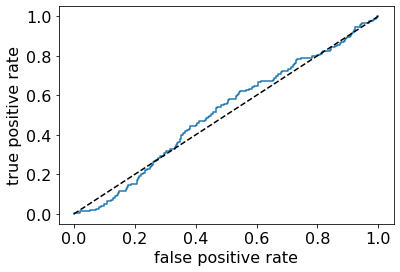

In [160]:
fpr, tpr, thresholds = roc_curve(y_test, random_preds)

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');

A popular metric is the area under the curve (AUC):

In [161]:
from sklearn.metrics import roc_auc_score

In [163]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.9694099408630454

In [164]:
roc_auc_score(y_test, random_preds)

0.511330125515638

![](https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/cutoff.gif)

#### Area under the curve (AUC)

- AUC provides a single meaningful number for systems performance 
- AUC of 1.0 means perfect classification and AUC of 0.5 means random chance

![](https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/ROC.gif)

## Break (5 min)

## Addressing class imbalance (10 min)


#### Unbalanced training sets

- This typically refers to having many more examples of one class than another in one's training set.
- Our Credit Card Fraud dataset is unbalanced.
- A lot of problems are coming from this class imbalance.

#### Do I want to address the problem?

- An important question is whether the class imbalance is a problem.
- Ask yourself, do I care about type I errors more than type II errors?
- If not, then it's fine to have a confusion matrix like we have for logistic regression:

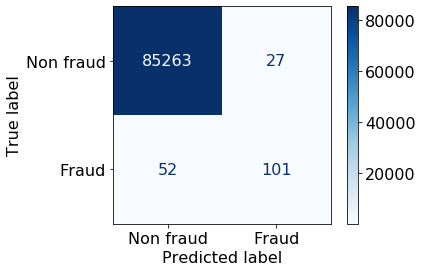

In [168]:
plot_confusion_matrix(lr, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd');

However, I'd say it's probably not fine to have a confusion matrix like the one for SVM:

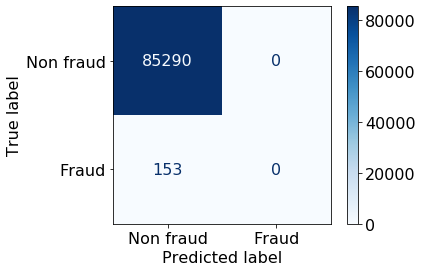

In [171]:
plot_confusion_matrix(svm, X_test, y_test,
                             display_labels=['Non fraud', 'Fraud'],
                             cmap=plt.cm.Reds, 
                             values_format = 'd');

because you probably don't want a model that never predicts "fraud"...

#### Class weight

- Many sklearn classifiers have a parameter called `class_weight`.
- This allows you to specify that one class is more important than another.
- For example, maybe a false negative is 10x more problematic than a false positive. 

In [172]:
lr_weight = LogisticRegression(max_iter=500, class_weight={1:10}) # set fraud a weight of 10
lr_weight.fit(X_train, y_train);

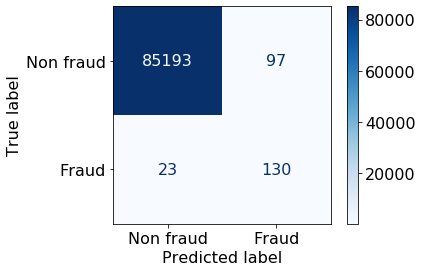

In [173]:
plot_confusion_matrix(lr_weight, X_test, y_test, display_labels=['Non fraud', 'Fraud'], cmap=plt.cm.Blues, values_format = 'd');

- Notice we've predicted more Fraud this time.
- This was equivalent to saying "repeat every positive example 10x in the training set".
  - But repeating data would slow down the code, whereas this doesn't.
- A useful setting is `class_weight="balanced"`
- This sets the weights so that the classes are "equal"

In [174]:
lr_weight_balanced = LogisticRegression(max_iter=500, class_weight="balanced")
lr_weight_balanced.fit(X_train, y_train);

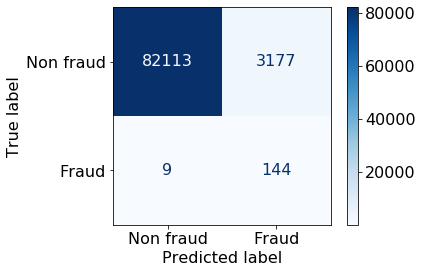

In [175]:
plot_confusion_matrix(lr_weight_balanced, X_test, y_test, display_labels=['Non fraud', 'Fraud'], cmap=plt.cm.Blues, values_format = 'd');

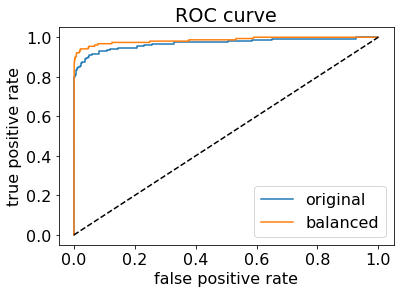

In [296]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, lr_weight_balanced.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label="original");
plt.plot(fpr2, tpr2, label="balanced");

plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title("ROC curve");
plt.legend();

- Above: the balanced version has a better ROC curve, even though it has worse accuracy (see below).
- We can make the plot again but this time showing the threshold=0.5 point:

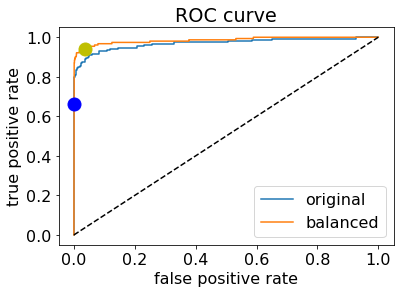

In [297]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, lr_weight_balanced.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label="original");
plt.plot(fpr2, tpr2, label="balanced");

ind = np.argmin(np.abs(thresholds-0.5))
plt.plot(fpr[ind], tpr[ind], 'bo', markersize=13)

ind2 = np.argmin(np.abs(thresholds2-0.5))
plt.plot(fpr2[ind2], tpr2[ind2], 'yo', markersize=13)

plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title("ROC curve");
plt.legend();

Important note: changing the class weight will **generally reduce accuracy**.

- The original model was trying to maximize accuracy.
- Now you're telling it to do something different.
- But that can be fine, accuracy isn't the only metric that matters.

In [177]:
show_scores(lr, X_train, y_train, X_test, y_test)

Training error: 0.0008
Test     error: 0.0009


In [178]:
show_scores(lr_weight, X_train, y_train, X_test, y_test)

Training error: 0.0013
Test     error: 0.0014


In [179]:
show_scores(lr_weight_balanced, X_train, y_train, X_test, y_test)

Training error: 0.0381
Test     error: 0.0373


- So what's going on here?
- Because there are so many more negative examples than positive, false positives affect accuracy much more than false negatives.
- Thus, precision matters a lot more than recall.
- So, the default method trades off a lot of recall for a bit of precision.
- This maximizes accuracy overall - but do we like it?

(optional) BTW, what is "balanced" doing exactly?

In [180]:
y_train.value_counts()

0    199025
1       339
Name: Class, dtype: int64

In [181]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
ratio

587.094395280236

- We have 587 times more negatives examples, so let's repeat our positive examples so that we have 587x more of them.
- Then the classes are "balanced".
- We can reproduce the result by explicitly setting the class weight:

In [182]:
lr_weight_balanced_2 = LogisticRegression(max_iter=500, class_weight={1:ratio})
lr_weight_balanced_2.fit(X_train, y_train);

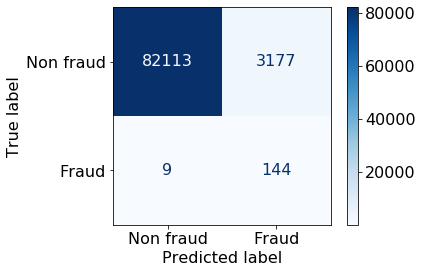

In [183]:
plot_confusion_matrix(lr_weight_balanced_2, X_test, y_test, display_labels=['Non fraud', 'Fraud'], cmap=plt.cm.Blues, values_format = 'd');

- A very important question to ask yourself: "Why do I have a class imbalance?"
  - Is it because one class is much more rare than the other?
  - Is it because of my data collection methods?
- If it's the data collection, then that means _your deployment and training data come from different distributions_!
  - It's reasonable to use `class_weight` to try and fix this.
  - If it's just because one is more rare than the other, you need to ask whether you care about one type of error more than the other.
  - If so, it's again reasonable to use `class_weight` to address this.
  
But, if you answer "no" to both question, it may be fine to just ignore the class imbalance.

#### A note about the predicted probabilities

- Note that if you set `class_weight` because you care about one type of error more than the other, the output of `predict_proba` loses some of its meaning.
- It's not really true that you have a 80% chance of fraud for this example. 
- It's really 20%, but you don't want false negatives.
- What we're really doing is changing the threshold, but it's common to do it this way.
- On the other hand, if you are using `class_weight` because it was harder to collect data for one of the classes, that is all fine.
- Be careful about how you interpret the probabilities in general, and extra careful when using `class_weight`!

#### Back to our dataset of the week

In [302]:
df = pd.read_csv('data/adult.csv')

In [303]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [304]:
X_train = df_train.drop(columns=['income'])
y_train = df_train['income']
X_test  = df_test.drop(columns=['income'])
y_test  = df_test['income']

In [305]:
numeric_features     = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

In [306]:
transformers=[
    ('scale', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(drop='first', sparse=False), categorical_features)]

In [307]:
preprocessor = ColumnTransformer(transformers=transformers)

In [308]:
preprocessor.fit(X_train);

In [309]:
new_columns = numeric_features + list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))

In [310]:
X_train_transformed = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_test_transformed  = pd.DataFrame(preprocessor.transform(X_test),  index=X_test.index,  columns=new_columns)

Question 1: do we have a class imbalance?

In [246]:
df_train['income'].value_counts()

<=50K    19810
>50K      6238
Name: income, dtype: int64

In [247]:
df_train['income'].value_counts()/len(df_train)

<=50K    0.760519
>50K     0.239481
Name: income, dtype: float64

Is this class imbalance a problem?

In [248]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_transformed, y_train);

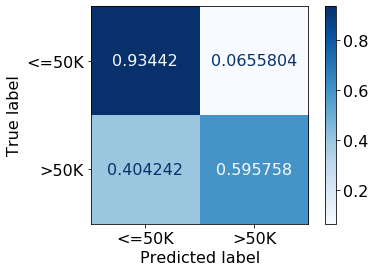

In [249]:
plot_confusion_matrix(lr, X_test_transformed, y_test, display_labels=df_train['income'].unique(), cmap=plt.cm.Blues, values_format = 'g', normalize="true");

- Can we use this information to improve our model?
- Well, why are we doing this in the first place?
- Are low/high income people more likely to fill out the census?
- Etc.

_These questions are just as important as choosing the "best" model, if not more important!_

## Stratified Splits (5 min)

- A similar idea of "balancing" classes can be applied to data splits.
- For example, with cross-validation, there is also [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).
- From the documentation:

> This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

- In other words, if we have 10% negative examples in total, then each fold will have 10% negative examples.
- We have the same option in `train_test_split` with the `stratify` argument. 
- Is this a good idea? 
  - Well, it's no longer a random sample, which is probably theoretically bad, but not that big of a deal.
  - If you have many examples, it shouldn't matter as much.
  - It can be especially useful in multi-class, say if you have one class with very few cases.
  - In general, these are difficult questions.

## This week - Summary (5 min)

- This week's dataset: predicting income level from adult census data.
  - Problem: I am too lazy to explore my dataset
  - Solution: `pandas_profiler`
  - Problem: numerical features: big values drown out other features.
  - Solution: scaling.
  - Problem: categorical features.
  - Solution: one-hot encoding and ordinal encoding (need domain knowledge to choose which one).
  - Problem: missing data.
  - Solution: impute something simple (legitimate concerns raised - we may come back to this in more depth)
  - Problem: how do I choose a model?
  - Solution: it's hard - but think about model complexity, speed, interpretability.
  - Problem: "I'm not sure if 15% accuracy is good?"
  - Solution: start with a baseline.
  - Problem: people spending too much time on fancy models.
  - Solution: start with a baseline!
  - Problem: "surely 99.9% accuracy is good?!"
  - Solution: look at metrics beyond accuracy (e.g. confusion matrix)
  - Problem: "I care more about false negatives than false positives"
  - Solution: change probability threshold or use `class_weight`
  - Problem: "I have a lot more negative examples in my dataset"
  - Solution: ask yourself, is that really a problem? If so, use `class_weight`
  - Problem: Hyperparameter optimization is a huge pain.
  - Solution: it is still a huge pain, but automated methods help a lot.

## Next week - current plan

- Regression: target value is continuous, not categorical
- I am planning on a real estate dataset: predicting house prices.
  - Let's see if I can find a good one.
- Some new and interesting problems related to regression.
  - E.g., should I scale my target values?
- Some new and interesting general problems.